## Batch image flattening with 2D plane using regression

#### Import packages and find all the *.nid files.

In [1]:
from NSFopen.read import read as afmreader

import os
from os import listdir
from os.path import isfile, join

import numpy as np
import math

import collections

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
%matplotlib inline

font = {'size': 12}
matplotlib.rc('font', **font)

dirpath = os.getcwd()
onlyfiles = [f for f in listdir(dirpath) if isfile(join(dirpath, f)) and f.split(".")[-1] == "nid"]
filenum = len(onlyfiles)
print(dirpath, "with", filenum,"*.nid files")
print(onlyfiles)

Q:\Marketing\Projects\Jupyter Notebooks\2D Plane Removal with 4 *.nid files
['circles.nid', 'circles_holes.nid', 'grid1.nid', 'squares_holes.nid']


#### Plane fitting and median search functions

In [41]:
def fit2DPlane(matrix, xaxis, yaxis):
    m = len(xaxis)
    X1, Y1 = np.meshgrid(xaxis, yaxis)
    X = np.hstack(( np.reshape(X1, (m*m, 1)) , np.reshape(Y1, (m*m, 1)) ))
    X = np.hstack(( np.ones((m*m, 1)) , X ))
    YY = np.reshape(matrix, (m*m, 1))

    theta = np.dot(np.dot( np.linalg.pinv(np.dot(X.transpose(), X)), X.transpose()), YY)
    plane = np.reshape(np.dot(X, theta), (m, m))
    
    return plane

def findLimits(matrix, strength):
    array1D = matrix.flatten()
    mean = np.mean(array1D)
    stdev = np.std(array1D)
    armin = mean - strength/2*stdev
    armax = mean + strength/2*stdev
    return armin, armax

In [9]:
rawdata0 = afmreader('grid1.nid', verbose=False).data

In [10]:
rawdata0['Image']['Forward']

Z-Axis       [[7.186671541805752e-07, 7.188438053975441e-07...
Amplitude    [[0.32497746869921684, 0.3225776180624962, 0.3...
Phase        [[81.04582741856575, 80.40699429810047, 79.109...
dtype: object

#### Define what to plot

In [42]:
signal_to_plot = 'Topography' # 'Amplitude', 'Z-Axis', 'Z-Axis Sensor' there could be more, i.e. 2nd lock-in signal, etc.
signal_to_plot1 = 'Z-Axis' 
scan_direction = 'Forward' # 'Forward', 'Backward', '2nd Forward', '2nd Backward'
scan_to_plot = 'Image' # 'Image', 'Spec' or 'Sweep'

#### Build X, Y axes and read data

In [43]:
# We store the images and respective X and Y axes in ordered dictionaries
data_dict = collections.OrderedDict()
xaxis_dict = collections.OrderedDict()
yaxis_dict = collections.OrderedDict()
data_levelled = collections.OrderedDict()

# Read the data into the dictionaries, depending on the version of the file,
# there could be various identifiers, i.e. 'Topography' or 'Z-Axis'.
for filename in onlyfiles:
    try:
        rawdata0 = afmreader(filename, verbose=False).data
        rawdata = rawdata0[scan_to_plot][scan_direction][signal_to_plot]*1e9
    except:
        print(filename) # Print filenames with outdated (old) identifiers
        rawdata0 = afmreader(filename, verbose=False).data
        rawdata = rawdata0[scan_to_plot][scan_direction][signal_to_plot1]*1e9
    
    param = afmreader(filename).param
    xrange = param['X']['range'][0]
    yrange = param['Y']['range'][0]
    
    key = filename.split(".nid")[0]
    xaxis = np.linspace(0, xrange*1E6, len(rawdata[0]))
    xaxis_dict[key] = xaxis
    
    yaxis = np.linspace(0, yrange*1E6, len(rawdata))
    yaxis_dict[key] = yaxis
    
    data = np.array(rawdata, dtype = 'float')
    data_dict[key] = data

grid1.nid


#### Apply plane fitting to all the data

In [44]:
for key in data_dict.keys():
    data = data_dict[key]
    xaxis = xaxis_dict[key]
    yaxis = yaxis_dict[key]
    
    plane = fit2DPlane(data, xaxis, yaxis)  
    data_levelled[key] = data-plane

#### Exclude rogue points

In [45]:
for key in data_levelled.keys():
    data = data_levelled[key]
    armin, armax = findLimits(data, 3) # 3 -means the range of the z-axis on the colorbar is 3 standard deviations.
    data_levelled[key] = np.clip(data, armin, armax)

#### Prepare the figure and plot

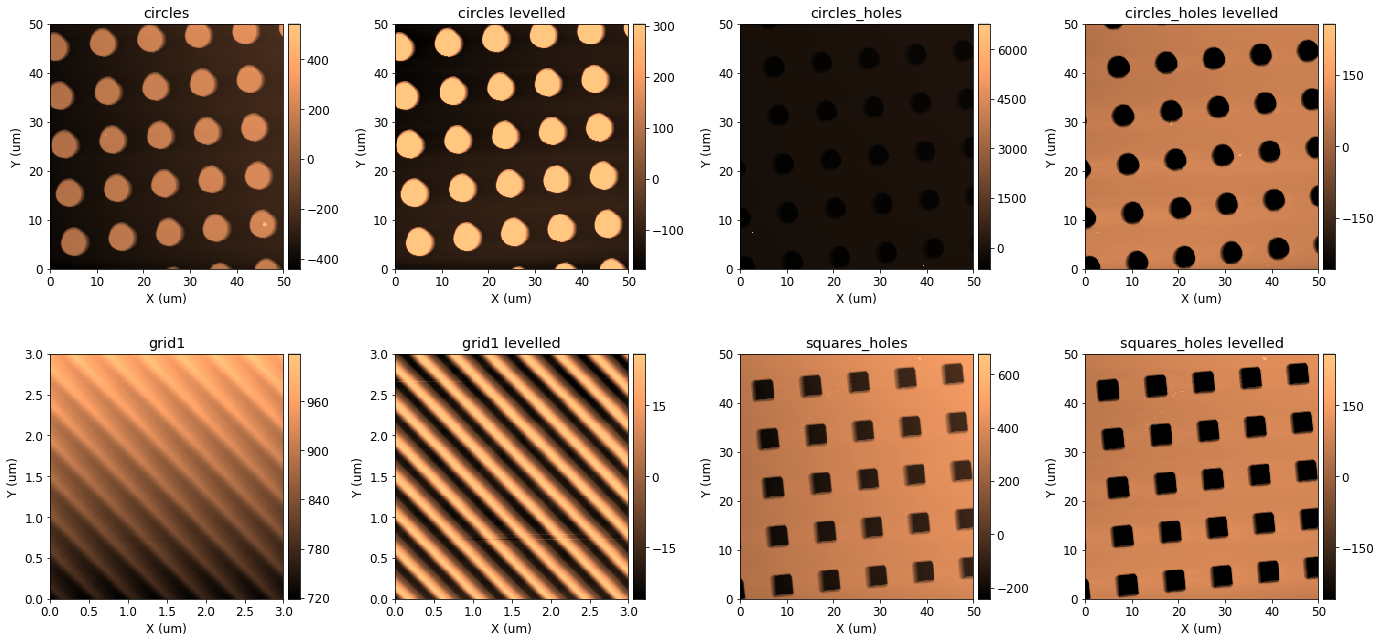

In [60]:
im = collections.OrderedDict() # Create a dictionary for the plots
cb = collections.OrderedDict()
cmap = "copper" # colormap
xlbl = 'X (um)'
ylbl = 'Y (um)'
axnum = 0

plot_columns = 4
plot_rows = math.ceil(len(data_dict)*2/plot_columns)

fig, axarr = plt.subplots(plot_rows, plot_columns, figsize=(5*plot_columns,5*plot_rows))
fig.tight_layout(pad=5.0)

for ax in axarr.flat:
    if axnum <= filenum*2-1:
        dict_key = onlyfiles[math.floor(axnum/2)].split(".nid")[0]

        if axnum%2 == 0:
            im[str(axnum)] = ax.pcolormesh(xaxis_dict[dict_key], yaxis_dict[dict_key], data_dict[dict_key], cmap = cmap)
            ax.set_title(dict_key)
        if axnum%2 == 1:
            im[str(axnum)] = ax.pcolormesh(xaxis_dict[dict_key], yaxis_dict[dict_key], data_levelled[dict_key], cmap = cmap)
            ax.set_title(dict_key + ' levelled')

        ax.set(xlabel=xlbl, ylabel=ylbl)
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        cb[str(axnum)] = colorbar(im[str(axnum)], cax=cax)
        #cb[str(axnum)].ax.set_ylabel("Z (nm)")
        axnum += 1